In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os
from pathlib import Path

# change this to your name exactly as required by the task
candidate_name = "Nandini"   # <- replace with your name (no spaces if instruction needs it)
project_root = Path(f"/content/ds_{candidate_name}")
csv_folder = project_root / "csv_files"
outputs_folder = project_root / "outputs"
notebooks_folder = project_root / "notebooks"  # optional

# create the folders (exist_ok=True avoids error if they already exist)
csv_folder.mkdir(parents=True, exist_ok=True)
outputs_folder.mkdir(parents=True, exist_ok=True)
notebooks_folder.mkdir(parents=True, exist_ok=True)

print("Local project folders created at:", project_root)
!ls -R /content | sed -n '1,120p'


Local project folders created at: /content/ds_Nandini
/content:
drive
ds_Nandini
sample_data

/content/drive:
MyDrive

/content/drive/MyDrive:
AI Image Caption Recommendation System.docx
AI image caption recommendation system.ipynb - Colab - Google Chrome 2025-07-27 10-59-58.mp4
b2b.zip
book.zip
california_housing.csv
Colab Notebooks
Copy of Instagram-Data.csv
Courier_Company_-_Rates[1].csv
Delhi-Metro-Network.csv
Instagram-Data (1).csv
Instagram-Data.csv
Internship Details.xlsx
loan-recovery.csv
metro dataset.zip
nand adhar.pdf
Nandini Resume (2).pdf
Nandini resume.pdf
Nandini R - Full Stack Web Developer Intern Offer Letter and Internship Agreement signed.pdf
Order_Report.csv
peacock1.png
project22_db.sql
RealEstate.csv
Resume Nandini (1).pdf
Resume Nandini.pdf
stock_data.csv
taxi_trip_data[1].csv
test.txt
train.txt
trips[2].txt
val.txt

/content/drive/MyDrive/Colab Notebooks:
AI image caption recommendation system.ipynb
app.py
Copy of EDA on Industry Dataet.ipynb
data cleaning on e-

In [89]:

drive_base = Path("/content/drive/MyDrive")  # change if needed
drive_project_root = drive_base / f"ds_{candidate_name}"
(drive_project_root / "csv_files").mkdir(parents=True, exist_ok=True)
(drive_project_root / "outputs").mkdir(parents=True, exist_ok=True)
(drive_project_root / "notebooks").mkdir(parents=True, exist_ok=True)

print("Drive project folders created at:", drive_project_root)


Drive project folders created at: /content/drive/MyDrive/ds_Nandini


In [90]:
import pandas as pd

# Paths to uploaded files
# Use the project_root and csv_folder variables defined in the previous cells
trades_path = csv_folder / 'historical_data.csv'
sent_path = csv_folder / 'fear_greed_index.csv'

# Read both CSVs, specifying dtype for column 12
trades = pd.read_csv(trades_path, dtype={11: str}) # Assuming column 12 is index 11
sentiment = pd.read_csv(sent_path)

print("✅ Files Loaded")
print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

✅ Files Loaded
Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


In [91]:
# --- Find the classification column dynamically (case-insensitive) ---
cols_lower = [c.lower() for c in sentiment.columns]
if 'classification' in cols_lower:
    class_col = sentiment.columns[cols_lower.index('classification')]
else:
    raise KeyError("❌ Could not find 'Classification' column in dataset.")

# --- Inspect unique categories ---
print("\nUnique sentiment labels before encoding:")
print(sentiment[class_col].unique())

# --- Define mapping (customize if dataset has more categories) ---
mapping = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}

# --- Create numeric conversion ---
sentiment['classification_numeric'] = sentiment[class_col].map(mapping)

# Handle any unmapped labels
if sentiment['classification_numeric'].isna().any():
    print("\n⚠️ Warning: Some labels were not in mapping! Check these:")
    print(sentiment.loc[sentiment['classification_numeric'].isna(), class_col].unique())

# --- Save the updated dataset ---
encoded_path = csv_folder / 'fear_greed_encoded.csv'
sentiment.to_csv(encoded_path, index=False)

print(f"\n✅ Successfully encoded and saved as: {encoded_path}")
print("Preview:")
print(sentiment[[class_col, 'classification_numeric']].head())


Unique sentiment labels before encoding:
['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']

✅ Successfully encoded and saved as: /content/ds_Nandini/csv_files/fear_greed_encoded.csv
Preview:
  classification  classification_numeric
0           Fear                       1
1   Extreme Fear                       0
2           Fear                       1
3   Extreme Fear                       0
4   Extreme Fear                       0


In [92]:
# Convert time/date columns to datetime, specifying formats
trades['Timestamp'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s', errors='coerce')

# Drop duplicates and missing dates (now checking for NaT after to_datetime)
trades.drop_duplicates(inplace=True)
sentiment.drop_duplicates(inplace=True)
trades = trades.dropna(subset=['Timestamp']) # Check for NaT in Timestamp
sentiment = sentiment.dropna(subset=['timestamp']) # Check for NaT in timestamp

# Create 'date' columns for merging and aggregation (keeping as datetime for now)
trades['date'] = trades['Timestamp']
sentiment['date'] = sentiment['timestamp']


# Save cleaned CSVs
trades.to_csv(csv_folder / 'trades_cleaned.csv', index=False)
sentiment.to_csv(csv_folder / 'fear_greed_cleaned.csv', index=False)

print("✅ Cleaned files saved to:", csv_folder)

✅ Cleaned files saved to: /content/ds_Nandini/csv_files


In [94]:
# Re-create 'date' columns from original datetime columns to ensure correct dtype
trades['date'] = trades['Timestamp'].dt.date
sentiment['date'] = sentiment['timestamp'].dt.date

# Select relevant columns before aggregation
trades_agg = trades[['date', 'Closed PnL', 'Size Tokens', 'Size USD', 'Account']].copy()

# Aggregate daily total PnL, volume, Size USD, and unique accounts
daily_trades = (
    trades_agg.groupby('date')
          .agg({'Closed PnL': 'sum',
                'Size Tokens': 'sum',
                'Size USD': 'sum', # Added aggregation for Size USD
                'Account': 'nunique'})
          .reset_index()
)
daily_trades.rename(columns={'Account': 'unique_accounts'}, inplace=True)

# Merge with sentiment on date, using the numeric classification
merged = pd.merge(daily_trades, sentiment[['date', 'classification_numeric']], on='date', how='left')

# Rename classification_numeric column to classification in merged for consistency with plotting code
merged.rename(columns={'classification_numeric': 'classification'}, inplace=True)

# --- Debugging: Display merged DataFrame head and info ---
print("Merged DataFrame head after merge:")
display(merged.head())
print("\nMerged DataFrame info after merge:")
merged.info()
# --- End Debugging ---


# Save merged data
merged.to_csv(csv_folder / 'merged_data.csv', index=False)
print("✅ Merged dataset saved as 'merged_data.csv' in csv_files/")

Merged DataFrame head after merge:


,date,Closed PnL,Size Tokens,Size USD,unique_accounts,classification
0,2023-05-01,0.000000,0.25130,477.00,1,3.0
1,2023-12-05,0.000000,11.80901,50005.83,1,4.0
2,2023-12-14,-205.434737,4092.28901,113203.35,1,3.0
3,2023-12-15,-24.632034,3558.00000,10609.95,1,3.0
4,2023-12-16,0.000000,39897.00000,15348.77,1,3.0



Merged DataFrame info after merge:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             480 non-null    object 
 1   Closed PnL       480 non-null    float64
 2   Size Tokens      480 non-null    float64
 3   Size USD         480 non-null    float64
 4   unique_accounts  480 non-null    int64  
 5   classification   479 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 22.6+ KB
✅ Merged dataset saved as 'merged_data.csv' in csv_files/


In [95]:
print("Sentiment DataFrame head (date and classification_numeric):")
display(sentiment[['date', 'classification_numeric']].head())

print("\nSentiment DataFrame tail (date and classification_numeric):")
display(sentiment[['date', 'classification_numeric']].tail())

print("\nSentiment DataFrame info (date and classification_numeric):")
sentiment[['date', 'classification_numeric']].info()

Sentiment DataFrame head (date and classification_numeric):


,date,classification_numeric
0,2018-02-01,1
1,2018-02-02,0
2,2018-02-03,1
3,2018-02-04,0
4,2018-02-05,0



Sentiment DataFrame tail (date and classification_numeric):


,date,classification_numeric
2639,2025-04-28,2
2640,2025-04-29,3
2641,2025-04-30,3
2642,2025-05-01,2
2643,2025-05-02,3



Sentiment DataFrame info (date and classification_numeric):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    2644 non-null   object
 1   classification_numeric  2644 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.4+ KB


In [96]:
print(trades.columns)
# The line below is removed as it caused the error and will be added back once the correct column name is confirmed
# print(trades['Leverage'].dtype)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')


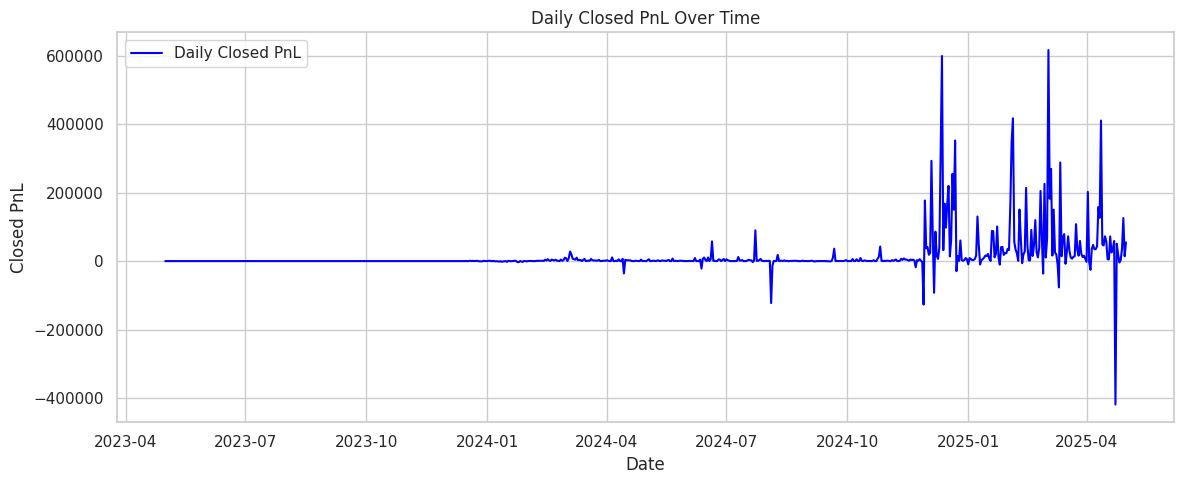

✅ Plot saved: /content/ds_Nandini/outputs/daily_closedPnL.png


In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(merged['date'], merged['Closed PnL'], label='Daily Closed PnL', color='blue')
plt.title('Daily Closed PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Closed PnL')
plt.legend()
plt.grid(True)

out1 = outputs_folder / 'daily_closedPnL.png'
plt.tight_layout()
plt.savefig(out1, dpi=150)
plt.show()
print(f"✅ Plot saved: {out1}")

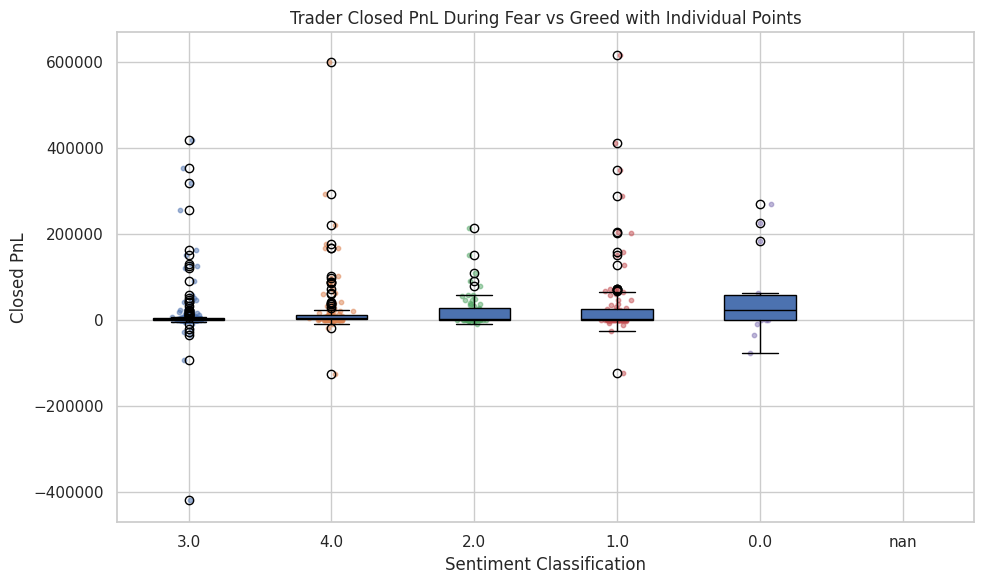

✅ Saved: /content/ds_Nandini/outputs/pnl_fear_vs_greed_with_points.png


In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot PnL during Fear vs Greed using matplotlib's boxplot and adding individual points
plt.figure(figsize=(10, 6)) # Increased figure size for better visualization

# Create the boxplot
data_to_plot = [merged[merged['classification'] == category]['Closed PnL'].dropna() for category in merged['classification'].unique()]
labels = merged['classification'].unique()
plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True, medianprops={'color': 'black'}) # Added patch_artist and medianprops for better appearance

# Add individual data points with jitter
for i, category in enumerate(labels):
    y_values = merged[merged['classification'] == category]['Closed PnL'].dropna()
    # Add jitter to x-values
    x_values = np.random.normal(i + 1, 0.04, size=len(y_values)) # Center jitter around box position (i+1)

    plt.scatter(x_values, y_values, alpha=0.5, s=10) # Scatter plot for individual points

plt.title('Trader Closed PnL During Fear vs Greed with Individual Points')
plt.xlabel('Sentiment Classification'); plt.ylabel('Closed PnL')
out2 = outputs_folder / 'pnl_fear_vs_greed_with_points.png' # Changed output filename
plt.tight_layout(); plt.savefig(out2, dpi=150); plt.show()
print(f"✅ Saved: {out2}")

In [100]:
print("Daily Trades DataFrame head (date):")
display(daily_trades.head())

print("\nDaily Trades DataFrame tail (date):")
display(daily_trades.tail())

print("\nDaily Trades DataFrame info (date):")
daily_trades.info()

Daily Trades DataFrame head (date):


,date,Closed PnL,Size Tokens,Size USD,unique_accounts
0,2023-05-01,0.000000,0.25130,477.00,1
1,2023-12-05,0.000000,11.80901,50005.83,1
2,2023-12-14,-205.434737,4092.28901,113203.35,1
3,2023-12-15,-24.632034,3558.00000,10609.95,1
4,2023-12-16,0.000000,39897.00000,15348.77,1



Daily Trades DataFrame tail (date):


,date,Closed PnL,Size Tokens,Size USD,unique_accounts
475,2025-04-27,2702.067468,3.887430e+06,487537.69,9
476,2025-04-28,36906.813759,2.152493e+05,26124921.49,8
477,2025-04-29,125749.613427,2.974820e+05,34089511.66,7
478,2025-04-30,14003.797269,1.559761e+05,12693878.85,8
479,2025-05-01,54536.829297,1.018552e+05,10720240.52,11



Daily Trades DataFrame info (date):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             480 non-null    object 
 1   Closed PnL       480 non-null    float64
 2   Size Tokens      480 non-null    float64
 3   Size USD         480 non-null    float64
 4   unique_accounts  480 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 18.9+ KB


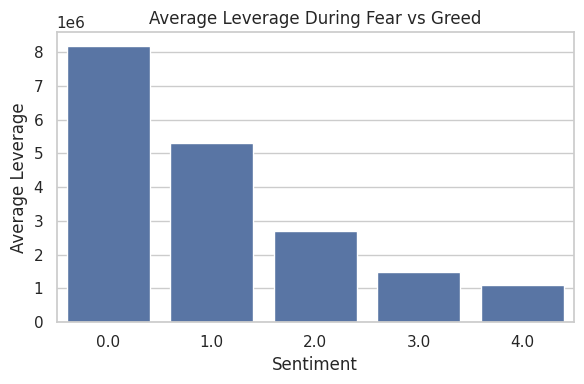

✅ Plot saved: /content/ds_Nandini/outputs/avg_leverage_fear_greed.png


In [101]:
avg_lev = merged.groupby('classification')['Size USD'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='Size USD', data=avg_lev)
plt.title('Average Leverage During Fear vs Greed')
plt.xlabel('Sentiment')
plt.ylabel('Average Leverage')

out3 = outputs_folder / 'avg_leverage_fear_greed.png'
plt.tight_layout()
plt.savefig(out3, dpi=150)
plt.show()
print(f"✅ Plot saved: {out3}")


In [102]:
print("Trades 'Timestamp' column head:")
print(trades['Timestamp'].head())

print("\nSentiment 'timestamp' column head:")
print(sentiment['timestamp'].head())

Trades 'Timestamp' column head:
0   2024-12-02 22:50:00
1   2024-12-02 22:50:00
2   2024-12-02 22:50:00
3   2024-12-02 22:50:00
4   2024-12-02 22:50:00
Name: Timestamp, dtype: datetime64[ns]

Sentiment 'timestamp' column head:
0   2018-02-01 05:30:00
1   2018-02-02 05:30:00
2   2018-02-03 05:30:00
3   2018-02-04 05:30:00
4   2018-02-05 05:30:00
Name: timestamp, dtype: datetime64[ns]


In [103]:
print("Merged DataFrame head:")
display(merged.head())

print("\nMerged DataFrame info:")
merged.info()

Merged DataFrame head:


,date,Closed PnL,Size Tokens,Size USD,unique_accounts,classification
0,2023-05-01,0.000000,0.25130,477.00,1,3.0
1,2023-12-05,0.000000,11.80901,50005.83,1,4.0
2,2023-12-14,-205.434737,4092.28901,113203.35,1,3.0
3,2023-12-15,-24.632034,3558.00000,10609.95,1,3.0
4,2023-12-16,0.000000,39897.00000,15348.77,1,3.0



Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             480 non-null    object 
 1   Closed PnL       480 non-null    float64
 2   Size Tokens      480 non-null    float64
 3   Size USD         480 non-null    float64
 4   unique_accounts  480 non-null    int64  
 5   classification   479 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 22.6+ KB


In [86]:
# Load raw data again to inspect original date strings
raw_trades = pd.read_csv(csv_folder / 'historical_data.csv')
raw_sentiment = pd.read_csv(csv_folder / 'fear_greed_index.csv')

print("Raw Trades 'Timestamp IST' column head:")
# Note: Using 'Timestamp IST' as per the column list in cell 5a0fd05e
print(raw_trades['Timestamp IST'].head())

print("\nRaw Sentiment 'timestamp' column head:")
print(raw_sentiment['timestamp'].head())

Raw Trades 'Timestamp IST' column head:
0    02-12-2024 22:50
1    02-12-2024 22:50
2    02-12-2024 22:50
3    02-12-2024 22:50
4    02-12-2024 22:50
Name: Timestamp IST, dtype: object

Raw Sentiment 'timestamp' column head:
0    1517463000
1    1517549400
2    1517635800
3    1517722200
4    1517808600
Name: timestamp, dtype: int64


In [108]:
import os

print("\n📂 CSV Files:")
for f in os.listdir(csv_folder):
    print("-", f)

print("\n🖼️ Output Plots:")
for f in os.listdir(outputs_folder):
    print("-", f)


📂 CSV Files:
- trades_cleaned.csv
- historical_data.csv
- fear_greed_cleaned.csv
- .ipynb_checkpoints
- fear_greed_encoded.csv
- fear_greed_index.csv
- merged_data.csv

🖼️ Output Plots:
- avg_leverage_fear_greed.png
- pnl_fear_vs_greed_with_points.png
- .ipynb_checkpoints
- daily_closedPnL.png


In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import os
import shutil
from pathlib import Path
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

# Define the source and destination paths
# Assuming project_root and drive_project_root are defined in previous cells
source_folder = project_root # This is /content/ds_Nandini
destination_folder = drive_project_root # This is /content/drive/MyDrive/ds_Nandini

print(f"Source folder: {source_folder}")
print(f"Destination folder: {destination_folder}")

# Ensure the destination folder exists in Google Drive
destination_folder.mkdir(parents=True, exist_ok=True)
print(f"Ensured destination folder exists: {destination_folder}")

# Copy the contents of the source folder to the destination folder
# Using shell command for robust copying including subdirectories and files
!cp -R "{source_folder}"/* "{destination_folder}/"

print(f"\n✅ Contents of {source_folder} copied to {destination_folder}")
print("Please use 'File > Save a copy to Drive' in the Colab menu to save your notebook.")

Google Drive is already mounted.
Source folder: /content/ds_Nandini
Destination folder: /content/drive/MyDrive/ds_Nandini
Ensured destination folder exists: /content/drive/MyDrive/ds_Nandini

✅ Contents of /content/ds_Nandini copied to /content/drive/MyDrive/ds_Nandini
Please use 'File > Save a copy to Drive' in the Colab menu to save your notebook.
